In [1]:
import boto3
import pandas as pd
import json
from configparser import ConfigParser
from langdetect import detect, DetectorFactory
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
parser = ConfigParser(interpolation=None)
parser.read('config.ini')

['config.ini']

In [3]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-2',
    aws_access_key_id = parser.get('passwords', 'key'),
    aws_secret_access_key = parser.get('passwords', 'secret_key')
)

In [4]:
biden_s3 = s3.Bucket('my-news-titles-data-bucket').Object('biden_news.json').get()

biden_data = biden_s3['Body'].read().decode('utf-8')

biden_parsed_data = json.loads(biden_data)

# Initialize an empty list to hold the rows
biden_rows = []

# Loop through the parsed data and create rows for the DataFrame
for entry in biden_parsed_data:
    date = entry['date']
    for title in entry['titles']:
        biden_rows.append({'Date': date, 'Title': title})

# Create the DataFrame from the rows
biden = pd.DataFrame(biden_rows)
biden

,Date,Title
0,2024-06-01,"Kaksi israelilaisministeriä uhkaa erota, jos t..."
1,2024-06-01,Varsities revamp fund: Only N200bn released ou...
2,2024-06-01,Trump's E. Jean Carroll lawyer says ex-preside...
3,2024-06-01,"Readers Write: The 'Abandon Biden' movement, r..."
4,2024-06-01,Deepfake w rosyjskich mediach. USA w rolu głównej
...,...,...
11929,2024-10-07,Ukraine-Krieg im Liveticker: +++ 14:17 Verteid...
11930,2024-10-07,Biden urges Congress to fund small business di...
11931,2024-10-07,Trump falsely claims Biden used FEMA funds for...
11932,2024-10-07,Hurricane Helene reveals a rudderless White Ho...


In [5]:
trump_s3 = s3.Bucket('my-news-titles-data-bucket').Object('trump_news.json').get()

trump_data = trump_s3['Body'].read().decode('utf-8')

trump_parsed_data = json.loads(trump_data)

# Initialize an empty list to hold the rows
trump_rows = []

# Loop through the parsed data and create rows for the DataFrame
for entry in trump_parsed_data:
    date = entry['date']
    for title in entry['titles']:
        trump_rows.append({'Date': date, 'Title': title})

# Create the DataFrame from the rows
trump = pd.DataFrame(trump_rows)
trump

,Date,Title
0,2024-06-01,Ukraine-Krieg im Liveticker: +++ 13:00 Medienb...
1,2024-06-01,Trump's E. Jean Carroll lawyer says ex-preside...
2,2024-06-01,"Readers Write: The 'Abandon Biden' movement, r..."
3,2024-06-01,Black leaders call out Trump criminal justice ...
4,2024-06-01,Thanks for nothing
...,...,...
11773,2024-10-07,25 Islamic Clerics Urge Muslims Across US to D...
11774,2024-10-07,Millions of Christians Not Voting Becomes 'Fiv...
11775,2024-10-07,Misinformation amid Helene recovery is 'extrem...
11776,2024-10-07,ANÁLISIS | Demasiada desinformación y poco din...


In [6]:
DetectorFactory.seed = 0

def clean_text(text):
    if text is None:
        return None
    # Remove unicode sequences
    text = re.sub(r'\\u[\dA-Fa-f]{4}', '', text)
    # Make text lowercase
    text = text.lower()
    # Detect and keep only English entries
    try:
        if detect(text) == 'en':
            return text
    except:
        return None
    return None

In [7]:
biden['Title'] = biden['Title'].apply(clean_text)
trump['Title'] = trump['Title'].apply(clean_text)

# Drop rows with None values (non-English entries)
biden.dropna(inplace=True)
trump.dropna(inplace=True)

biden.drop_duplicates(subset=['Title'], inplace=True)
trump.drop_duplicates(subset=['Title'], inplace=True)

biden['Date'] = pd.to_datetime(biden['Date'])
trump['Date'] = pd.to_datetime(trump['Date'])

# Remove entries with "Trump" in the Biden dataframe
biden_filtered = biden[~biden['Title'].apply(lambda x: 'trump' in x)]
# Remove entries with "Biden" in the Trump dataframe
trump_filtered = trump[~trump['Title'].apply(lambda x: 'biden' in x)]

In [8]:
biden_filtered

,Date,Title
1,2024-06-01,varsities revamp fund: only n200bn released ou...
3,2024-06-01,"readers write: the 'abandon biden' movement, r..."
5,2024-06-01,thanks for nothing
6,2024-06-01,"gaza mediators urge israel, hamas to accept tr..."
13,2024-06-01,travis kelce inducted into secret service prot...
...,...,...
6319,2024-08-08,ex-guantánamo detainee forcibly repatriated to...
6320,2024-08-08,is tim walz a progressive or a centrist — or b...
6324,2024-08-08,uncommitted minnesota delegates discuss concer...
6326,2024-08-08,pathway to legal status for undocumented spous...


EDA

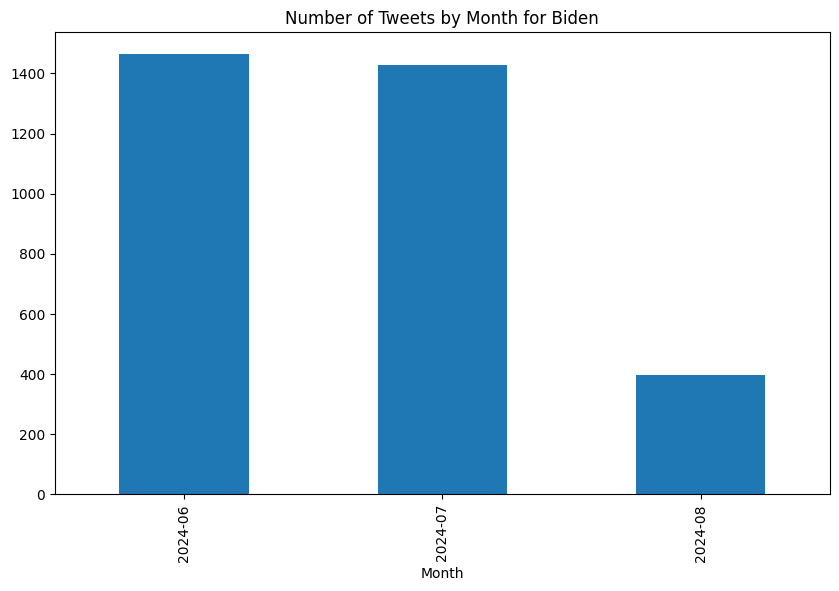

In [9]:
biden_filtered = biden_filtered.copy()
biden_filtered.loc[:, 'Month'] = biden_filtered['Date'].dt.to_period('M')

# Group by the 'Month' column and count the number of articles per month
monthly_counts = biden_filtered.groupby('Month').size()

# Plot the data
ax = monthly_counts.plot(kind='bar', figsize=(10, 6), title = 'Number of Tweets by Month for Biden')
plt.show()

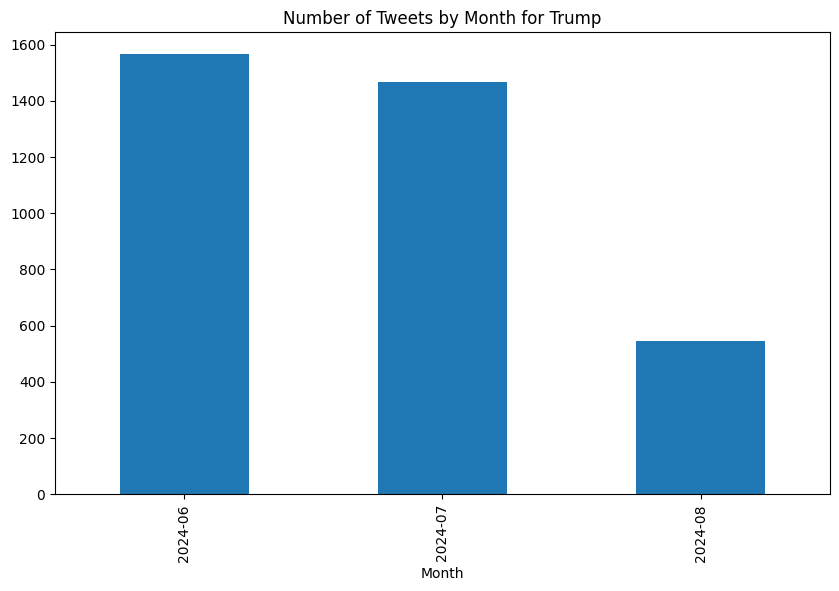

In [10]:
trump_filtered = trump_filtered.copy()
trump_filtered.loc[:, 'Month'] = trump_filtered['Date'].dt.to_period('M')

# Group by the 'Month' column and count the number of articles per month
monthly_counts = trump_filtered.groupby('Month').size()

# Plot the data
monthly_counts.plot(kind='bar', figsize=(10, 6), title = 'Number of Tweets by Month for Trump')
plt.show()

Analysis

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
biden_res = {}
for i, row in tqdm(biden_filtered.iterrows(), total=len(biden_filtered)):
    date = row['Date']
    title = row['Title']
    sentiment_scores = sia.polarity_scores(title)
    sentiment_scores['Date'] = date
    biden_res[title] = sentiment_scores

100%|██████████| 3289/3289 [00:02<00:00, 1150.15it/s]


In [13]:
biden_sent = pd.DataFrame.from_dict(biden_res, orient='index')
biden_sent.reset_index(inplace=True)
biden_sent.rename(columns={'index': 'Title'}, inplace=True)
biden_sent

,Title,neg,neu,pos,compound,Date
0,varsities revamp fund: only n200bn released ou...,0.000,1.000,0.000,0.0000,2024-06-01
1,"readers write: the 'abandon biden' movement, r...",0.273,0.526,0.201,-0.1280,2024-06-01
2,thanks for nothing,0.000,0.408,0.592,0.4404,2024-06-01
3,"gaza mediators urge israel, hamas to accept tr...",0.000,0.755,0.245,0.3818,2024-06-01
4,travis kelce inducted into secret service prot...,0.000,0.804,0.196,0.4423,2024-06-01
...,...,...,...,...,...,...
3284,ex-guantánamo detainee forcibly repatriated to...,0.000,0.594,0.406,0.6681,2024-08-08
3285,is tim walz a progressive or a centrist — or b...,0.000,1.000,0.000,0.0000,2024-08-08
3286,uncommitted minnesota delegates discuss concer...,0.328,0.672,0.000,-0.5994,2024-08-08
3287,pathway to legal status for undocumented spous...,0.000,0.857,0.143,0.1280,2024-08-08


In [14]:
bins = [-1, -0.6, -0.2, 0.2, 0.6, 1]
labels = ['-1 to -0.6', '-0.6 to -0.2', '-0.2 to 0.2', '0.2 to 0.6', '0.6 to 1']

# Create a new column with the binned data
biden_sent['Range'] = pd.cut(biden_sent['compound'], bins=bins, labels=labels, include_lowest=True)

# Group by the Range and calculate the sum of compound scores in each range
biden_grouped_sent = biden_sent.groupby('Range', observed=True)['compound'].count().reset_index().rename(columns={'compound': 'count'})
biden_grouped_sent

,Range,count
0,-1 to -0.6,333
1,-0.6 to -0.2,796
2,-0.2 to 0.2,1461
3,0.2 to 0.6,593
4,0.6 to 1,106


In [15]:
trump_res = {}
for i, row in tqdm(trump_filtered.iterrows(), total=len(trump_filtered)):
    date = row['Date']
    title = row['Title']
    sentiment_scores = sia.polarity_scores(title)
    sentiment_scores['Date'] = date
    trump_res[title] = sentiment_scores
trump_res

100%|██████████| 3577/3577 [00:03<00:00, 981.79it/s] 


{"trump's e. jean carroll lawyer says ex-president's attorneys know his big defense is a lie": {'neg': 0.0,
  'neu': 0.897,
  'pos': 0.103,
  'compound': 0.128,
  'Date': Timestamp('2024-06-01 00:00:00')},
 'black leaders call out trump criminal justice contradictions as he rails against guilty verdict...': {'neg': 0.388,
  'neu': 0.457,
  'pos': 0.155,
  'compound': -0.6249,
  'Date': Timestamp('2024-06-01 00:00:00')},
 'thanks for nothing': {'neg': 0.0,
  'neu': 0.408,
  'pos': 0.592,
  'compound': 0.4404,
  'Date': Timestamp('2024-06-01 00:00:00')},
 "'i'm no defender of blanche': ex-trump lawyer seems to take shot at current trial attorney": {'neg': 0.133,
  'neu': 0.783,
  'pos': 0.084,
  'compound': -0.2023,
  'Date': Timestamp('2024-06-01 00:00:00')},
 "labash: don't do the crime if you can't do the time...": {'neg': 0.0,
  'neu': 0.778,
  'pos': 0.222,
  'compound': 0.431,
  'Date': Timestamp('2024-06-01 00:00:00')},
 'charlamagne tha god tells cnn anchor no, black people won’t

In [16]:
trump_sent = pd.DataFrame.from_dict(trump_res, orient='index')
trump_sent.reset_index(inplace=True)
trump_sent.rename(columns={'index': 'Title'}, inplace=True)
trump_sent

,Title,neg,neu,pos,compound,Date
0,trump's e. jean carroll lawyer says ex-preside...,0.000,0.897,0.103,0.1280,2024-06-01
1,black leaders call out trump criminal justice ...,0.388,0.457,0.155,-0.6249,2024-06-01
2,thanks for nothing,0.000,0.408,0.592,0.4404,2024-06-01
3,'i'm no defender of blanche': ex-trump lawyer ...,0.133,0.783,0.084,-0.2023,2024-06-01
4,labash: don't do the crime if you can't do the...,0.000,0.778,0.222,0.4310,2024-06-01
...,...,...,...,...,...,...
3572,"trump attacked walz, harris and reporters in t...",0.200,0.800,0.000,-0.4588,2024-08-08
3573,microstrategy expands government ai solutions ...,0.000,0.659,0.341,0.2732,2024-08-08
3574,‘border czar’ kamala harris ‘unburdened’ herse...,0.000,0.821,0.179,0.3400,2024-08-08
3575,kamala harris leads trump by 5 points in lates...,0.000,1.000,0.000,0.0000,2024-08-08


In [17]:
# Create a new column with the binned data
trump_sent['Range'] = pd.cut(trump_sent['compound'], bins=bins, labels=labels, include_lowest=True)

# Group by the Range and calculate the sum of compound scores in each range
trump_grouped_sent = trump_sent.groupby('Range', observed=True)['compound'].count().reset_index().rename(columns={'compound': 'count'})
trump_grouped_sent

,Range,count
0,-1 to -0.6,356
1,-0.6 to -0.2,823
2,-0.2 to 0.2,1605
3,0.2 to 0.6,651
4,0.6 to 1,142


In [18]:
trump_grouped_sent['normalized'] = trump_grouped_sent['count'] / trump_grouped_sent['count'].sum()
biden_grouped_sent['normalized'] = biden_grouped_sent['count'] / biden_grouped_sent['count'].sum()

# Add a column to identify the group (Trump or Biden)
trump_grouped_sent['candidate'] = 'Trump'
biden_grouped_sent['candidate'] = 'Biden'

# Combine the data
combined_grouped_df = pd.concat([trump_grouped_sent, biden_grouped_sent])


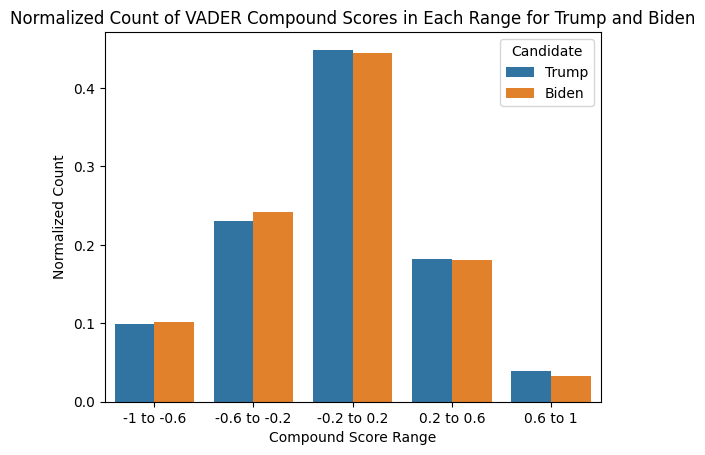

In [19]:
sns.barplot(x='Range', y='normalized', hue='candidate', data=combined_grouped_df)

# Add labels and title
plt.xlabel('Compound Score Range')
plt.ylabel('Normalized Count')
plt.title('Normalized Count of VADER Compound Scores in Each Range for Trump and Biden')
plt.legend(title='Candidate')
plt.show()

In [20]:
biden_compound_avg = biden_sent.groupby('Date')['compound'].mean().reset_index()

# Rename columns for clarity
biden_compound_avg.rename(columns={'compound': 'average_compound'}, inplace=True)
biden_compound_avg

,Date,average_compound
0,2024-06-01,-0.117978
1,2024-06-02,-0.034080
2,2024-06-03,-0.137332
3,2024-06-04,-0.123087
4,2024-06-05,-0.256664
...,...,...
64,2024-08-04,-0.003357
65,2024-08-05,-0.229640
66,2024-08-06,-0.138152
67,2024-08-07,-0.094178


In [21]:
biden_compound_avg = biden_sent.groupby('Date')['compound'].mean().reset_index()

# Rename columns for clarity
biden_compound_avg.rename(columns={'compound': 'average_compound'}, inplace=True)
biden_compound_avg

,Date,average_compound
0,2024-06-01,-0.117978
1,2024-06-02,-0.034080
2,2024-06-03,-0.137332
3,2024-06-04,-0.123087
4,2024-06-05,-0.256664
...,...,...
64,2024-08-04,-0.003357
65,2024-08-05,-0.229640
66,2024-08-06,-0.138152
67,2024-08-07,-0.094178
